<a href="https://colab.research.google.com/github/ahmadluthfiridho/VisiKomputerFinalProject_1301194142/blob/main/Visi_Komputer_Final_Project_1301194142.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [22]:
!git clone https://github.com/datitran/raccoon_dataset.git

fatal: destination path 'raccoon_dataset' already exists and is not an empty directory.


# Download Package

In [23]:
!git clone https://github.com/samson6460/tf2_YOLO.git

fatal: destination path 'tf2_YOLO' already exists and is not an empty directory.


# YOLO V1

In [24]:
from tf2_YOLO.yolov1_5 import Yolo

class_names = ['raccoon']
yolo = Yolo(class_names=class_names)

## Read file

In [25]:
img_path = "/content/raccoon_dataset/images"
label_path = "/content/raccoon_dataset/annotations"

train_img, train_label = yolo.read_file_to_dataset(
    img_path, label_path,
    label_format="labelimg",
    thread_num=50,
    shuffle=False)

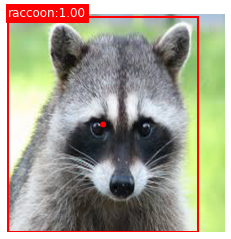

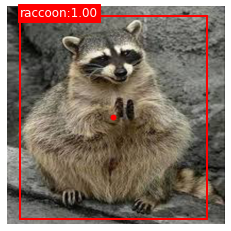

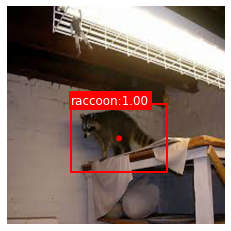

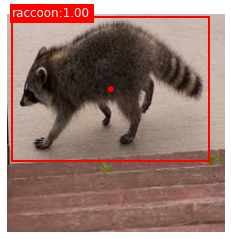

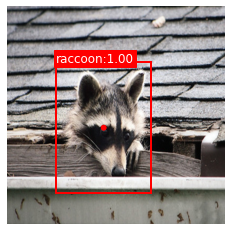

In [26]:
for i in range(5):
    yolo.vis_img(train_img[i], train_label[i])

## Split the data

In [27]:
test_img = train_img[-20:]
test_label = train_label[-20:]
print("shape of testing img:", test_img.shape)
print("shape of testing label:", test_label.shape)
print()

valid_img = train_img[160:180]
valid_label = train_label[160:180]
print("shape of validation img:", valid_img.shape)
print("shape of validation label:", valid_label.shape)
print()

train_img = train_img[:160]
train_label = train_label[:160]
print("shape of training img:", train_img.shape)
print("shape of training label:", train_label.shape)

shape of testing img: (20, 448, 448, 3)
shape of testing label: (20, 7, 7, 6)

shape of validation img: (20, 448, 448, 3)
shape of validation label: (20, 7, 7, 6)

shape of training img: (160, 448, 448, 3)
shape of training label: (160, 7, 7, 6)


## Create model

In [28]:
yolo.create_model()
yolo.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 224, 224, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 224, 224, 64  256        ['conv2d_25[0][0]']              
 ormalization)                  )                                                           

## Compile model

In [29]:
from utils.tools import get_class_weight

binary_weight = get_class_weight(
    train_label[..., 4:5],
    method='binary'
    )
print(binary_weight)

[0.02229756]


In [30]:
from tensorflow.keras.optimizers import Adam

loss = yolo.loss(
    binary_weight,
    loss_weight={
        "xy":5,
        "wh":5,
        "conf":1,
        "prob":1}
    )

metrics = yolo.metrics("obj_acc+mean_iou+recall")

yolo.model.compile(
    optimizer=Adam(learning_rate=5e-5),
    #optimizer=SGD(learning_rate=1e-10, momentum=0.9, decay=5e-4),
    loss=loss,
    metrics=metrics
    )

## Train model

In [31]:
train_history = yolo.model.fit(
    train_img,
    train_label,
    epochs=30,
    batch_size=5,
    verbose=1,
    validation_data=(valid_img, valid_label)
    )

Epoch 1/30
32/32 [==============================] - 10s 214ms/step - loss: 2.4753 - obj_acc: 0.2651 - mean_iou: 0.5516 - recall: 0.6369 - val_loss: 1.9643 - val_obj_acc: 0.4827 - val_mean_iou: 0.5547 - val_recall: 0.7417
Epoch 2/30
32/32 [==============================] - 6s 188ms/step - loss: 1.6946 - obj_acc: 0.5588 - mean_iou: 0.6214 - recall: 0.7844 - val_loss: 1.4731 - val_obj_acc: 0.8878 - val_mean_iou: 0.5943 - val_recall: 0.8726
Epoch 3/30
32/32 [==============================] - 6s 189ms/step - loss: 1.3984 - obj_acc: 0.7690 - mean_iou: 0.6174 - recall: 0.7588 - val_loss: 1.2434 - val_obj_acc: 0.9214 - val_mean_iou: 0.6161 - val_recall: 0.9583
Epoch 4/30
32/32 [==============================] - 6s 192ms/step - loss: 1.2862 - obj_acc: 0.8744 - mean_iou: 0.6310 - recall: 0.7720 - val_loss: 1.1583 - val_obj_acc: 0.9469 - val_mean_iou: 0.5969 - val_recall: 0.7333
Epoch 5/30
32/32 [==============================] - 6s 191ms/step - loss: 1.1265 - obj_acc: 0.9189 - mean_iou: 0.6382 -

## Predict and evaluate

In [32]:
prediction = yolo.model.predict(test_img)

1/1 [==============================] - 0s 406ms/step


### Visualize some results

In [33]:
yolo.vis_img?

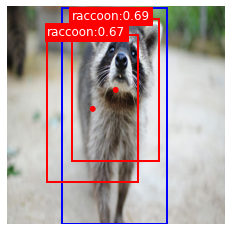

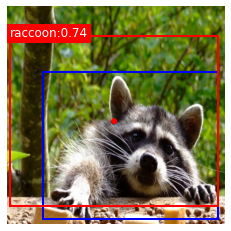

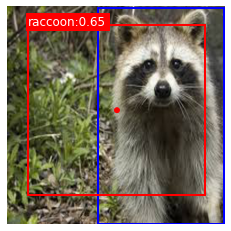

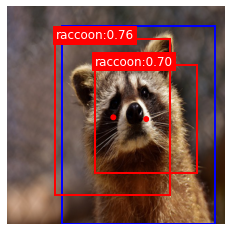

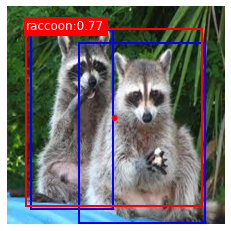

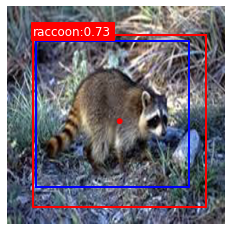

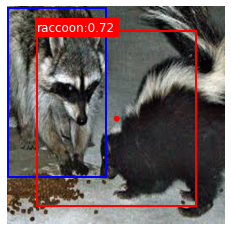

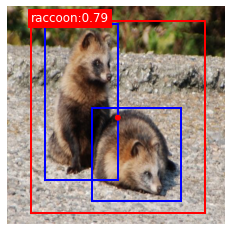

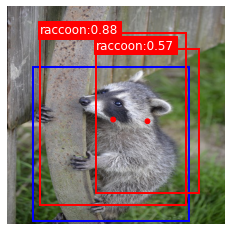

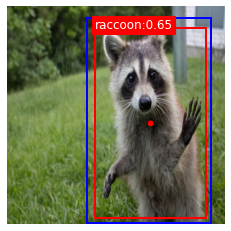

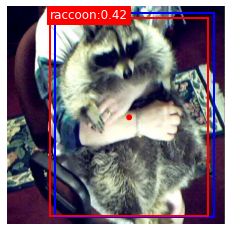

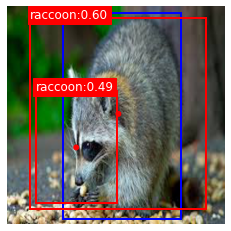

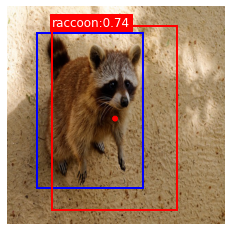

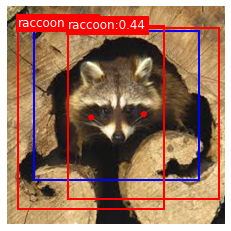

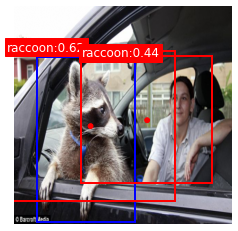

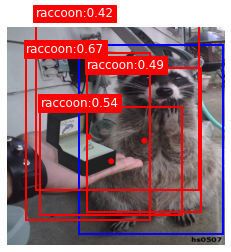

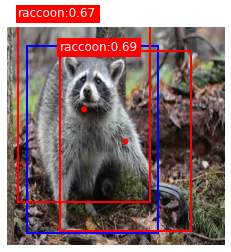

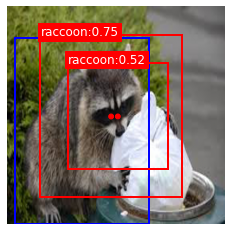

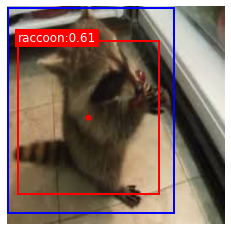

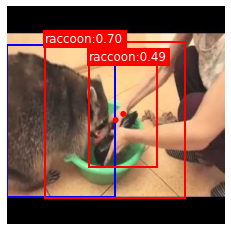

In [34]:
for i in range(len(test_img)):
    fig_ax = yolo.vis_img(
        test_img[i],
        test_label[i],
        text_fontsize=0,
        box_color="b",
        point_radius=0,   
        return_fig_ax=True
        )
    yolo.vis_img(
        test_img[i],
        prediction[i],
        conf_threshold=0.4,
        nms_mode=1,
        nms_threshold=0.5,
        fig_ax=fig_ax
        )

### Show score table

In [35]:
from utils.measurement import create_score_mat

In [36]:
create_score_mat(
    test_label,
    prediction,
    class_names=yolo.class_names,
    nms_mode=1,
    nms_threshold=0.5,
    conf_threshold=0.4,
    version=1)

,precision,recall,F1-score,gts,dets
raccoon,0.5,0.727273,0.592593,22,32


### Show PR curve and AP

In [37]:
from utils.measurement import PR_func

In [38]:
PR_func?

In [39]:
pr = PR_func(
    test_label,
    prediction,
    class_names=yolo.class_names,
    nms_mode=1,
    nms_threshold=0.5,
    version=1
    )

print("precision at recall=0.5:", pr(0.5))

precision at recall=0.5: 0.6363636363636364


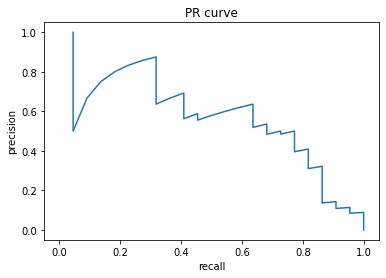

In [40]:
pr.plot_pr_curve(smooth=False)

In [41]:
pr.get_map(mode="voc2012")

,ap
raccoon,0.646104
mAP,0.646104
